Авдеев Роман 317
Ансамбли алгоритмов. Эксперименты.

In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import re
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from ensembles import RandomForestMSE, GradientBoostingMSE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.preprocessing import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler

import matplotlib
import matplotlib.pyplot as plt
# import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
data = pd.read_csv(r"C:\Users\Авдеев\Desktop\ноутбуки прак и ммро\прак\Ensembles\kc_house_data.csv")

# Предобработка данных

In [3]:
data.shape

(21613, 21)

In [4]:
data.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [5]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [6]:
data['id'].value_counts()

795000620     3
8651510380    2
2568300045    2
9353300600    2
4139480200    2
             ..
2767603649    1
1446403617    1
5602000275    1
1786200010    1
1523300157    1
Name: id, Length: 21436, dtype: int64

Удалили неинформативный признак 'id':

In [3]:
data = data.drop(['id'], axis=1)

## категориальные

Категориальных: 9 признаков (date, floors, waterfront, view, condition, grade, yr_built, yr_renovated, zipcode)

In [8]:
data['date'].value_counts()

20140623T000000    142
20140626T000000    131
20140625T000000    131
20140708T000000    127
20150427T000000    126
                  ... 
20141102T000000      1
20150131T000000      1
20150524T000000      1
20140517T000000      1
20140727T000000      1
Name: date, Length: 372, dtype: int64

In [9]:
data['floors'].value_counts()

1.0    10680
2.0     8241
1.5     1910
3.0      613
2.5      161
3.5        8
Name: floors, dtype: int64

In [10]:
data['waterfront'].value_counts()

0    21450
1      163
Name: waterfront, dtype: int64

In [11]:
data['view'].value_counts()

0    19489
2      963
3      510
1      332
4      319
Name: view, dtype: int64

In [12]:
data['condition'].value_counts()

3    14031
4     5679
5     1701
2      172
1       30
Name: condition, dtype: int64

In [13]:
data['grade'].value_counts()

7     8981
8     6068
9     2615
6     2038
10    1134
11     399
5      242
12      90
4       29
13      13
3        3
1        1
Name: grade, dtype: int64

In [14]:
data['yr_built'].value_counts()

2014    559
2006    454
2005    450
2004    433
2003    422
       ... 
1933     30
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64

In [15]:
data['yr_renovated'].value_counts()

0       20699
2014       91
2013       37
2003       36
2005       35
        ...  
1951        1
1959        1
1948        1
1954        1
1944        1
Name: yr_renovated, Length: 70, dtype: int64

In [16]:
data['zipcode'].value_counts()

98103    602
98038    590
98115    583
98052    574
98117    553
        ... 
98102    105
98010    100
98024     81
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

## вещественные

Все остальные признаки считаю вещественными: 12 признаков

## Обработка

In [4]:
categ = ['date', 'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated', 'zipcode']
numer = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

In [18]:
print('Список столбцов, в которых есть NaN:', data.columns[data.isna().any()].tolist())
print('Количество таких столбцов:', len(data.columns[data.isna().any()].tolist()))

Список столбцов, в которых есть NaN: []
Количество таких столбцов: 0


Следовательно, нет смысла применять SimpleImputer

Далее разделим данные на Х и целевую переменную (цена)

In [5]:
y = data['price']
X = data.drop(['price'], axis=1)

Переведем данные в numpy.ndarray :

Закодируем категориальные признаки как счетчики со сглаживанием (из 4-го задания ММРО помним, что счетчики показали себя лучше, чем OHE) - в моем случае

А для вещественных признаков будем использовать StandardScaler

In [6]:
scaler = StandardScaler()
te = TargetEncoder(cols=categ, smoothing=10)

scaled_columns = scaler.fit_transform(X[numer]) 
encoded_columns = te.fit_transform(X[categ], y)

processed_data = pd.DataFrame(np.concatenate([scaled_columns, encoded_columns], axis=1))

C:\Users\Авдеев\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."


In [7]:
y = y.to_numpy()
X = processed_data.to_numpy()

Поделим данные на обучающую и тестовую выборки в пропорции 7 : 3

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Эксперимент 2 (случайный лес)

## Количество деревьев

In [102]:
n_ests = np.arange(1, 210, 5)

In [103]:
rmse_s = []
time_s = []

for n_est in n_ests:
    time_start = time.time()
    model = RandomForestMSE(n_estimators=n_est, feature_subsample_size=10)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    time_s.append(time.time() - time_start)
    rmse_s.append(mean_squared_error(y_pred=y_pred, y_true=y_test, squared=False))

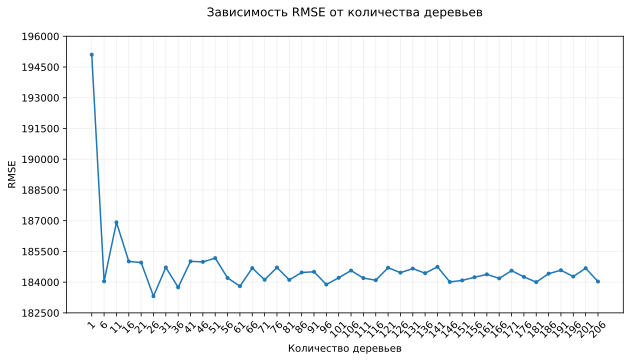

In [108]:
plt.figure(figsize=(10, 5))
plt.title('Зависимость RMSE от количества деревьев', pad=20)
plt.xlabel('Количество деревьев')
plt.ylabel('RMSE')

plt.plot(n_ests, rmse_s, marker='.')
plt.xticks(np.arange(1, 210, step=5), rotation=45)
plt.yticks(np.arange(182500, 197500, step=1500))
plt.grid(linestyle="-", alpha=.2)
plt.show()

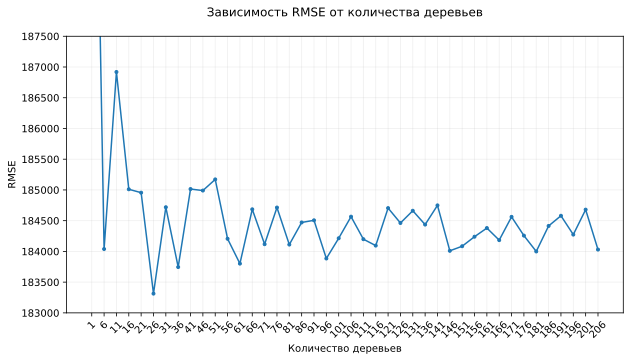

In [111]:
plt.figure(figsize=(10, 5))
plt.title('Зависимость RMSE от количества деревьев', pad=20)
plt.xlabel('Количество деревьев')
plt.ylabel('RMSE')

plt.plot(n_ests, rmse_s, marker='.')
plt.xticks(np.arange(1, 210, step=5), rotation=45)
plt.grid(linestyle="-", alpha=.2)
plt.ylim((183000, 187500))
plt.show()

In [113]:
print('Минимальная ошибка RMSE =',min(rmse_s), ' достигается при n_estimators =',n_ests[np.argmin(rmse_s)])

Минимальная ошибка RMSE = 183313.06862686612  достигается при n_estimators = 26


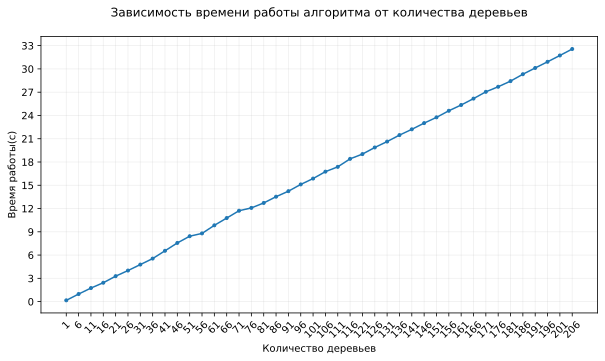

In [117]:
plt.figure(figsize=(10, 5))
plt.title('Зависимость времени работы алгоритма от количества деревьев', pad=20)
plt.xlabel('Количество деревьев')
plt.ylabel('Время работы(с)')

plt.plot(n_ests, time_s, marker='.')
plt.xticks(np.arange(1, 210, step=5), rotation=45)
plt.yticks(np.arange(0, 36, step=3))
plt.grid(linestyle="-", alpha=.2)
plt.show()

## Размерность подвыборки

In [119]:
subsamples = np.arange(1, 20, 1)

In [120]:
rmse_s = []
time_s = []

for subsample in subsamples:
    time_start = time.time()
    model = RandomForestMSE(n_estimators=26, feature_subsample_size=subsample)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    time_s.append(time.time() - time_start)
    rmse_s.append(mean_squared_error(y_pred=y_pred, y_true=y_test, squared=False))

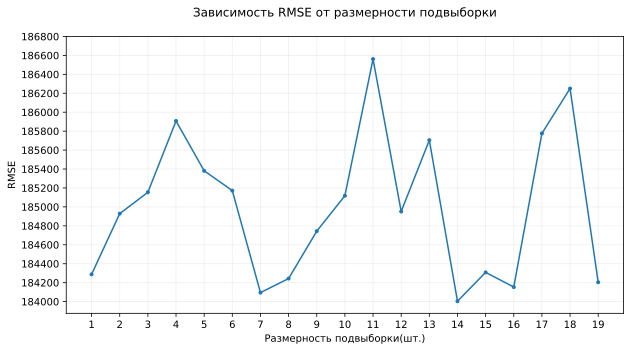

In [126]:
plt.figure(figsize=(10, 5))
plt.title('Зависимость RMSE от размерности подвыборки', pad=20)
plt.xlabel('Размерность подвыборки(шт.)')
plt.ylabel('RMSE')

plt.plot(subsamples, rmse_s, marker='.')
plt.xticks(np.arange(1, 20, step=1))
plt.yticks(np.arange(184000, 187000, step=200))
plt.grid(linestyle="-", alpha=.2)
plt.show()

In [128]:
print('Минимальная ошибка RMSE =',min(rmse_s), ' достигается при feature_subsample_size =',subsamples[np.argmin(rmse_s)])

Минимальная ошибка RMSE = 184003.79409950718  достигается при feature_subsample_size = 14


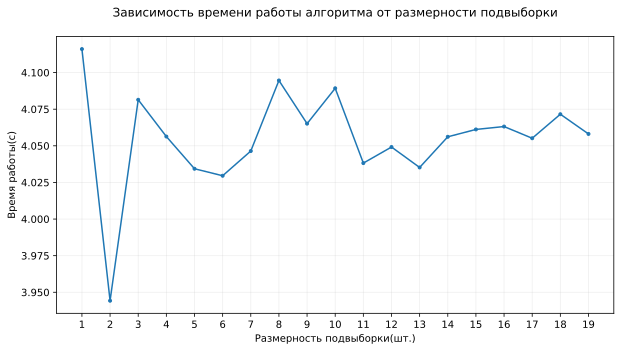

In [127]:
plt.figure(figsize=(10, 5))
plt.title('Зависимость времени работы алгоритма от размерности подвыборки', pad=20)
plt.xlabel('Размерность подвыборки(шт.)')
plt.ylabel('Время работы(с)')

plt.plot(subsamples, time_s, marker='.')
plt.xticks(np.arange(1, 20, step=1))
plt.grid(linestyle="-", alpha=.2)
plt.show()

## Максимальная глубина поддерева

In [129]:
max_depths = np.linspace(1, 32, 32)

In [130]:
rmse_s = []
time_s = []

for max_depth in max_depths:
    time_start = time.time()
    model = RandomForestMSE(n_estimators=26, feature_subsample_size=14, max_depth=int(max_depth))

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    time_s.append(time.time() - time_start)
    rmse_s.append(mean_squared_error(y_pred=y_pred, y_true=y_test, squared=False))

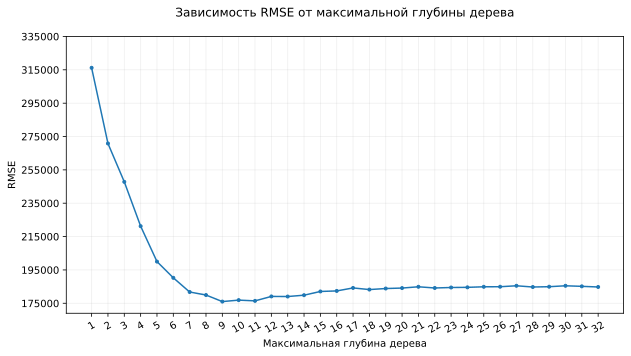

In [131]:
plt.figure(figsize=(10, 5))
plt.title('Зависимость RMSE от максимальной глубины дерева', pad=20)
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('RMSE')

plt.plot(max_depths, rmse_s, marker='.')
plt.grid(linestyle="-", alpha=.2)
plt.xticks(np.arange(1, 33, step=1), rotation=30)
plt.yticks(np.arange(175000, 340000, step=20000))
plt.show()

In [132]:
print('Минимальная ошибка RMSE =',min(rmse_s), ' достигается при feature_subsample_size =',max_depths[np.argmin(rmse_s)])

Минимальная ошибка RMSE = 176024.9012914231  достигается при feature_subsample_size = 9.0


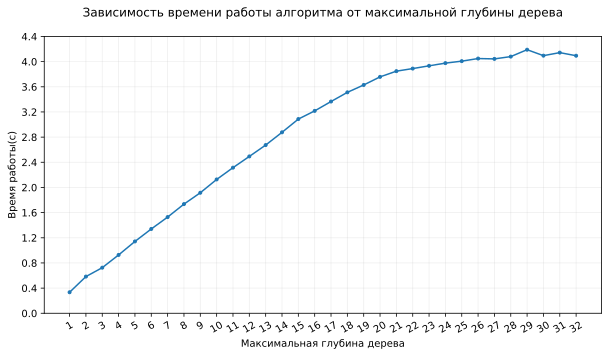

In [136]:
plt.figure(figsize=(10, 5))
plt.title('Зависимость времени работы алгоритма от максимальной глубины дерева', pad=20)
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('Время работы(с)')

plt.plot(max_depths, time_s, marker='.')
plt.grid(linestyle="-", alpha=.2)
plt.xticks(np.arange(1, 33, step=1), rotation=30)
plt.yticks(np.arange(0, 4.6, step=0.4))
plt.show()

Случай, когда глубина неограничена:

In [137]:
time_start = time.time()
model = RandomForestMSE(n_estimators=26, feature_subsample_size=14)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
    
print('Время работы алгоритма(с):', time.time() - time_start)
print('RMSE=', mean_squared_error(y_pred=y_pred, y_true=y_test, squared=False))

Время работы алгоритма(с): 4.040189743041992
RMSE= 185341.10194699033


# Эксперимент 3 (градиентный бустинг)

## Количество деревьев

In [9]:
n_ests = np.arange(1, 210, 5)

In [10]:
rmse_s = []
time_s = []

for n_est in n_ests:
    time_start = time.time()
    model = GradientBoostingMSE(n_estimators=n_est, feature_subsample_size=10)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    time_s.append(time.time() - time_start)
    rmse_s.append(mean_squared_error(y_pred=y_pred, y_true=y_test, squared=False))

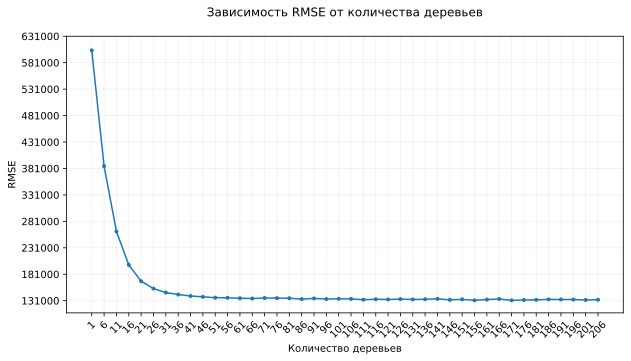

In [19]:
plt.figure(figsize=(10, 5))
plt.title('Зависимость RMSE от количества деревьев', pad=20)
plt.xlabel('Количество деревьев')
plt.ylabel('RMSE')

plt.plot(n_ests, rmse_s, marker='.')
plt.xticks(np.arange(1, 210, step=5), rotation=45)
plt.yticks(np.arange(131000, 650000, step=50000))
plt.grid(linestyle="-", alpha=.2)
plt.show()

In [15]:
print('Минимальная ошибка RMSE =',min(rmse_s), ' достигается при n_estimators =',n_ests[np.argmin(rmse_s)])

Минимальная ошибка RMSE = 131571.6711519204  достигается при n_estimators = 171


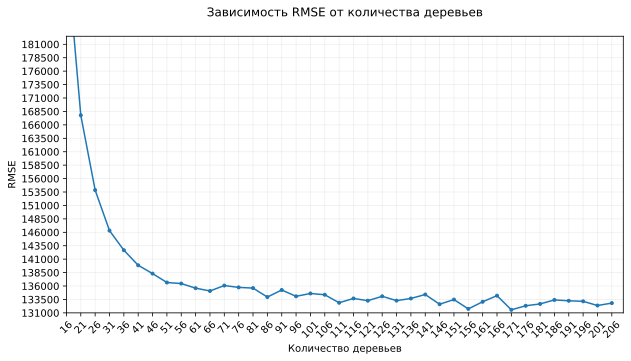

In [29]:
plt.figure(figsize=(10, 5))
plt.title('Зависимость RMSE от количества деревьев', pad=20)
plt.xlabel('Количество деревьев')
plt.ylabel('RMSE')

plt.plot(n_ests, rmse_s, marker='.')
plt.xticks(np.arange(1, 210, step=5), rotation=45)
plt.yticks(np.arange(131000, 183000, step=2500))
plt.ylim((131000, 182500))
plt.xlim((16, 210))
plt.grid(linestyle="-", alpha=.2)
plt.show()

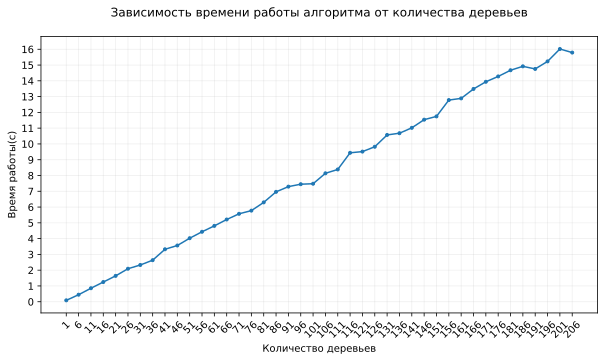

In [31]:
plt.figure(figsize=(10, 5))
plt.title('Зависимость времени работы алгоритма от количества деревьев', pad=20)
plt.xlabel('Количество деревьев')
plt.ylabel('Время работы(с)')

plt.plot(n_ests, time_s, marker='.')
plt.xticks(np.arange(1, 210, step=5), rotation=45)
plt.yticks(np.arange(0, 17, step=1))
plt.grid(linestyle="-", alpha=.2)
plt.show()

## Размерность подвыборки

In [32]:
subsamples = np.arange(1, 20, 1)

In [33]:
rmse_s = []
time_s = []

for subsample in subsamples:
    time_start = time.time()
    model = GradientBoostingMSE(n_estimators=171, feature_subsample_size=subsample)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    time_s.append(time.time() - time_start)
    rmse_s.append(mean_squared_error(y_pred=y_pred, y_true=y_test, squared=False))

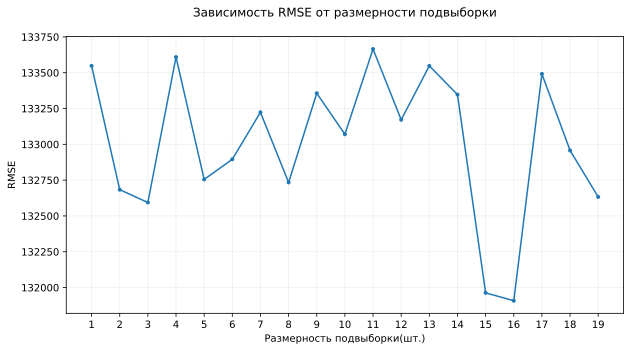

In [37]:
plt.figure(figsize=(10, 5))
plt.title('Зависимость RMSE от размерности подвыборки', pad=20)
plt.xlabel('Размерность подвыборки(шт.)')
plt.ylabel('RMSE')

plt.plot(subsamples, rmse_s, marker='.')
plt.xticks(np.arange(1, 20, step=1))
plt.grid(linestyle="-", alpha=.2)
plt.show()

In [38]:
print('Минимальная ошибка RMSE =',min(rmse_s), ' достигается при feature_subsample_size =',subsamples[np.argmin(rmse_s)])

Минимальная ошибка RMSE = 131907.94183556456  достигается при feature_subsample_size = 16


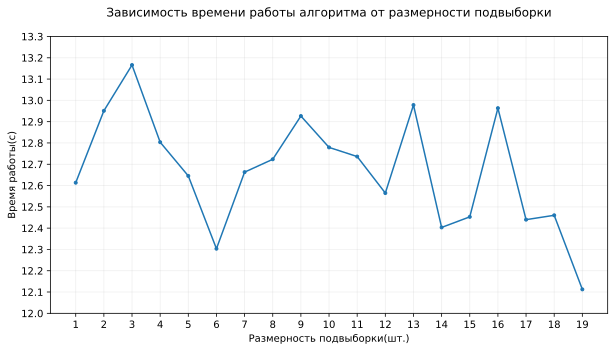

In [44]:
plt.figure(figsize=(10, 5))
plt.title('Зависимость времени работы алгоритма от размерности подвыборки', pad=20)
plt.xlabel('Размерность подвыборки(шт.)')
plt.ylabel('Время работы(с)')

plt.plot(subsamples, time_s, marker='.')
plt.xticks(np.arange(1, 20, step=1))
plt.yticks(np.arange(12, 13.3, step=0.1))
plt.grid(linestyle="-", alpha=.2)
plt.show()

## Максимальная глубина

In [45]:
max_depths = np.linspace(1, 32, 32)

In [46]:
rmse_s = []
time_s = []

for max_depth in max_depths:
    time_start = time.time()
    model = RandomForestMSE(n_estimators=171, feature_subsample_size=16, max_depth=int(max_depth))

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    time_s.append(time.time() - time_start)
    rmse_s.append(mean_squared_error(y_pred=y_pred, y_true=y_test, squared=False))

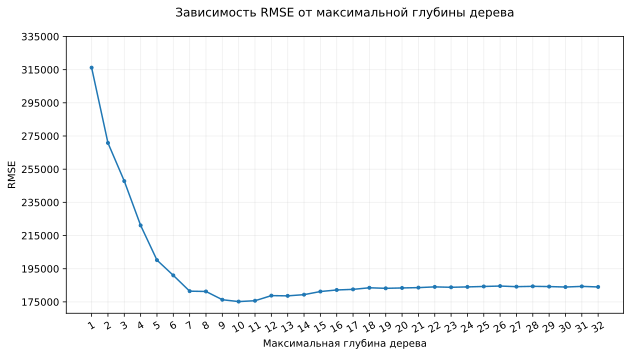

In [47]:
plt.figure(figsize=(10, 5))
plt.title('Зависимость RMSE от максимальной глубины дерева', pad=20)
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('RMSE')

plt.plot(max_depths, rmse_s, marker='.')
plt.grid(linestyle="-", alpha=.2)
plt.xticks(np.arange(1, 33, step=1), rotation=30)
plt.yticks(np.arange(175000, 340000, step=20000))
plt.show()

In [55]:
print('Минимальная ошибка RMSE =',min(rmse_s), ' достигается при max_depth =',max_depths[np.argmin(rmse_s)])

Минимальная ошибка RMSE = 175191.20663883083  достигается при max_depth = 10.0


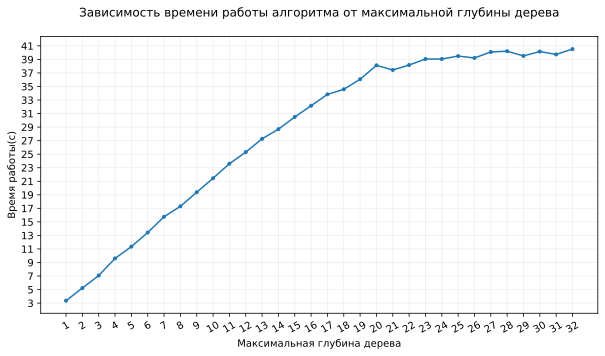

In [54]:
plt.figure(figsize=(10, 5))
plt.title('Зависимость времени работы алгоритма от максимальной глубины дерева', pad=20)
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('Время работы(с)')

plt.plot(max_depths, time_s, marker='.')
plt.grid(linestyle="-", alpha=.2)
plt.xticks(np.arange(1, 33, step=1), rotation=30)
plt.yticks(np.arange(3, 42, step=2))
plt.show()

Случай, когда глубина неограничена:

In [56]:
time_start = time.time()
model = RandomForestMSE(n_estimators=26, feature_subsample_size=14)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
    
print('Время работы алгоритма(с):', time.time() - time_start)
print('RMSE=', mean_squared_error(y_pred=y_pred, y_true=y_test, squared=False))

Время работы алгоритма(с): 4.183691740036011
RMSE= 184425.584833394


## Выбранный learning rate

In [58]:
l_rates = np.logspace(-5, -1, 20)

In [59]:
rmse_s = []
time_s = []

for lr in l_rates:
    time_start = time.time()
    model = GradientBoostingMSE(n_estimators=171, feature_subsample_size=16, max_depth=10, learning_rate=lr)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    time_s.append(time.time() - time_start)
    rmse_s.append(mean_squared_error(y_pred=y_pred, y_true=y_test, squared=False))

In [60]:
print('Минимальная ошибка RMSE =',min(rmse_s), ' достигается при learning_rate =',l_rates[np.argmin(rmse_s)])

Минимальная ошибка RMSE = 143371.83877866712  достигается при learning_rate = 0.06158482110660261


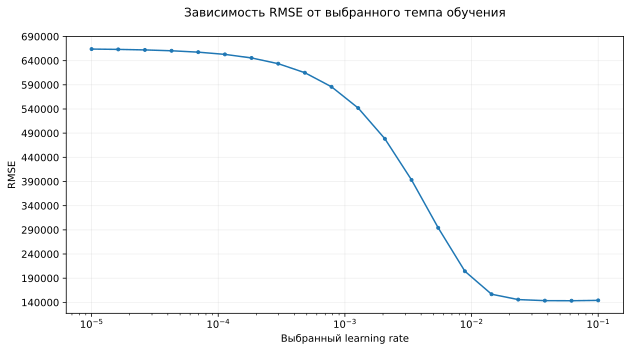

In [62]:
plt.figure(figsize=(10, 5))
plt.title('Зависимость RMSE от выбранного темпа обучения', pad=20)
plt.xlabel('Выбранный learning rate')
plt.ylabel('RMSE')

plt.plot(l_rates, rmse_s, marker='.')
plt.yticks(np.arange(140000, 700000, step=50000))
plt.grid(linestyle="-", alpha=.2)
plt.xscale('log')
plt.show()

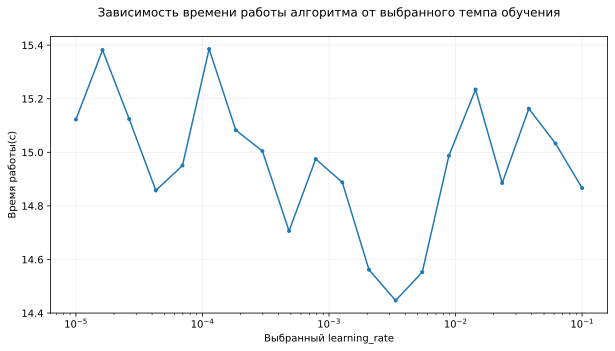

In [66]:
plt.figure(figsize=(10, 5))
plt.title('Зависимость времени работы алгоритма от выбранного темпа обучения', pad=20)
plt.xlabel('Выбранный learning_rate')
plt.ylabel('Время работы(с)')

plt.plot(l_rates, time_s, marker='.')
plt.xscale('log')
plt.grid(linestyle="-", alpha=.2)
plt.show()